In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import sklearn
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve

# get all versions of the libraries
print("pandas:", pd.__version__)
import matplotlib as mpl
print("matplotlib:", mpl.__version__)
print("seaborn:", sns.__version__)
import xgboost as xgb
print("xgboost:", xgb.__version__)
print("sklearn:", sklearn.__version__)

pandas: 2.2.2
matplotlib: 3.9.2
seaborn: 0.13.2
xgboost: 2.1.1
sklearn: 1.2.2


In [ ]:
curl -L -o ~/Downloads/creditcardfraud.zip\
  https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud

SyntaxError: invalid syntax (2659465916.py, line 2)

In [5]:
df = pd.read_csv("creditcard.csv")

## Look at first few rows

In [ ]:
print(df.head())
print(df['Class'].value_counts(normalize=True))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Plot Class Distribution in Dataset

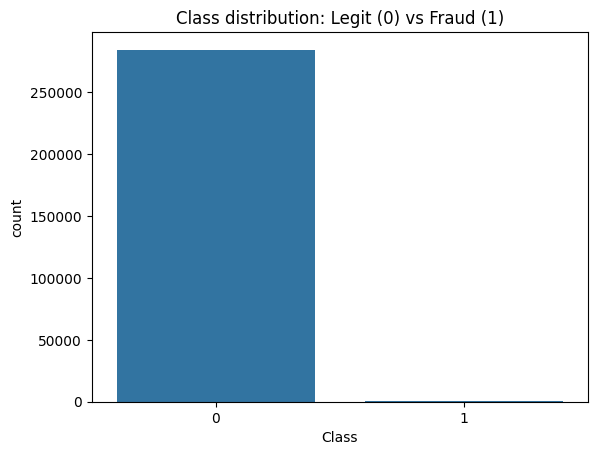

Class
0    284315
1       492
Name: count, dtype: int64
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [7]:
sns.countplot(x="Class", data=df)
plt.title("Class distribution: Legit (0) vs Fraud (1)")
plt.show()

print(df['Class'].value_counts())
print(df['Class'].value_counts(normalize=True))

## Sort Dataset by Time

In [8]:
# sort by time
df = df.sort_values('Time')

# 80% train, 20% test
cut = int(len(df) * 0.8)
train = df.iloc[:cut]
test  = df.iloc[cut:]

x_train = train.drop('Class', axis=1)
y_train = train['Class']
x_test  = test.drop('Class', axis=1)
y_test  = test['Class']

print("Train shape:", x_train.shape, "Test shape:", x_test.shape)
print("Train fraud ratio:", y_train.mean(), "Test fraud ratio:", y_test.mean())

Train shape: (227845, 30) Test shape: (56962, 30)
Train fraud ratio: 0.001830191577607584 Test fraud ratio: 0.001316667251852112


## Train

In [9]:
# fraud weight ratio
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=5
)

model.fit(x_train, y_train)


/Users/28zhany/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [16:10:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Predictions

In [12]:
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ap = average_precision_score(y_test, y_pred_proba)
print("Average Precision (AUPRC):", ap)



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.86      0.73      0.79        75

    accuracy                           1.00     56962
   macro avg       0.93      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Average Precision (AUPRC): 0.7860091350946901
